#Práctica 3, segunda parte: Caltech-UCSD. Pablo Rodríguez Fernández.
En este archivo se encuentra el tercer apartado de la práctica 3, relativo a ResNet50 y el dataset Caltech-UCSD. Se separa de los otros dos debido a las limitaciones de RAM de Colab.

El dataset utilizado puede obtenerse en: http://www.vision.caltech.edu/visipedia/CUB-200.html

Para que la carga de las imágenes sea lo más rápida posible, se recomienda que las imágenes junto con los archivos train.txt y test.txt estén en un archivo zip dentro de la carpeta imágenes. Si es así, ejecutar esta celda. Si no, ejecutar la siguiente solamente

In [ ]:
# Directorio de trabajo
DIR = "/content/drive/My Drive/Colab Notebooks/images/caltech" 
from google.colab import drive
drive.mount("/content/drive")
# Extraer archivos
print("\nEliminando datos anteriores...")
! rm -rf "$DIR"
print("\nExtrayendo datos...")
! unzip -q "/content/drive/My Drive/Colab Notebooks/images/caltech.zip" -d "/content/drive/My Drive/Colab Notebooks/images/caltech"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Eliminando datos anteriores...

Extrayendo datos...


Ejecutar esta celda si las imágenes y los archivos train.txt y test.txt se encuentran en la carpeta "Colab Notebooks/images" (ruta genérica para las imágenes de las prácticas)

In [ ]:
from google.colab import drive
drive.mount("/content/drive")
DIR = "/content/drive/My Drive/Colab Notebooks/images" 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Preparativos


In [ ]:
#########################################################################
################ CARGAR LAS LIBRERÍAS NECESARIAS ########################
#########################################################################

# Importar librerías necesarias
import numpy as np
from matplotlib import pyplot 
import tensorflow as tf
import keras
import keras.utils as np_utils

#Vamos a usar el recolector de basura para ahorrar recursos en Colab
import gc

# Lectura y preprocesamiento de datos
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator

# Importar el optimizador a usar
from tensorflow.keras.optimizers import SGD

# Importar modelos y capas específicas que se van a usar
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization,Activation

# Importar el modelo ResNet50 y su respectiva función de preprocesamiento,
# que es necesario pasarle a las imágenes para usar este modelo
from tensorflow.keras.applications.resnet50 import ResNet50 #Modelo
from tensorflow.keras.applications.resnet50 import preprocess_input #Funcion de preprocesamiento

#HIPERPARAMETROS
INPUT = (224,224)
INPUT_SHAPE = (224,224,3)
BATCH_SIZE = 128
NUM_CLASSES = 200
EPOCHS = 50

Como en los apartados anteriores, comenzamos importando las librerías necesarias y estableciendo los hiperparámetros generales.

En este caso debemos importar también el modelo ya entrenado de ResNet50, así como su función de preprocesado, la cual es necesaria para adaptar las imágenes de entrada a las admitidas por ResNet.

#Funciones proporcionadas

In [ ]:
#########################################################################
################## FUNCIÓN PARA LEER LAS IMÁGENES #######################
#########################################################################

# Dado un fichero train.txt o test.txt y el path donde se encuentran los
# ficheros y las imágenes, esta función lee las imágenes
# especificadas en ese fichero y devuelve las imágenes en un vector y 
# sus clases en otro.

def leerImagenes(vec_imagenes, path):
  clases = np.array([img.split('/')[0] for img in vec_imagenes])
  imagenes = np.array([img_to_array(load_img(path + "/" + img, 
                                             target_size = (224, 224))) 
                       for img in vec_imagenes])
  return imagenes,clases


In [ ]:
#########################################################################
############# FUNCIÓN PARA CARGAR EL CONJUNTO DE DATOS ##################
#########################################################################

# Usando la función anterior, y dado el path donde se encuentran las
# imágenes y los archivos "train.txt" y "test.txt", devuelve las 
# imágenes y las clases de train y test para usarlas con keras
# directamente.

def cargarDatos(path):
  # Cargamos los ficheros
  train_images = np.loadtxt(path + "/train.txt", dtype = str)
  test_images = np.loadtxt(path + "/test.txt", dtype = str)
  # Leemos las imágenes con la función anterior
  train, train_clases = leerImagenes(train_images,path)
  test, test_clases = leerImagenes(test_images,path)
  
  # Pasamos los vectores de las clases a matrices 
  # Para ello, primero pasamos las clases a números enteros
  clases_posibles = np.unique(np.copy(train_clases))
  for i in range(len(clases_posibles)):
    train_clases[train_clases == clases_posibles[i]] = i
    test_clases[test_clases == clases_posibles[i]] = i

  # Después, usamos la función to_categorical()
  train_clases = keras.utils.np_utils.to_categorical(train_clases, 200)
  test_clases = keras.utils.np_utils.to_categorical(test_clases, 200)
  
  # Barajar los datos
  train_perm = np.random.permutation(len(train))
  train = train[train_perm]
  train_clases = train_clases[train_perm]

  test_perm = np.random.permutation(len(test))
  test = test[test_perm]
  test_clases = test_clases[test_perm]
  
  return train, train_clases, test, test_clases

In [ ]:
#########################################################################
######## FUNCIÓN PARA OBTENER EL ACCURACY DEL CONJUNTO DE TEST ##########
#########################################################################

# Esta función devuelve el accuracy de un modelo, definido como el 
# porcentaje de etiquetas bien predichas frente al total de etiquetas.
# Como parámetros es necesario pasarle el vector de etiquetas verdaderas
# y el vector de etiquetas predichas, en el formato de keras (matrices
# donde cada etiqueta ocupa una fila, con un 1 en la posición de la clase
# a la que pertenece y 0 en las demás).

def calcularAccuracy(labels, preds):
  labels = np.argmax(labels, axis = 1)
  preds = np.argmax(preds, axis = 1)
  
  accuracy = sum(labels == preds)/len(labels)
  
  return accuracy

In [ ]:
#########################################################################
## FUNCIÓN PARA PINTAR LA PÉRDIDA Y EL ACCURACY EN TRAIN Y VALIDACIÓN ###
#########################################################################

# Esta función pinta dos gráficas, una con la evolución de la función
# de pérdida en el conjunto de train y en el de validación, y otra
# con la evolución del accuracy en el conjunto de train y en el de
# validación. Es necesario pasarle como parámetro el historial
# del entrenamiento del modelo (lo que devuelven las funciones
# fit() y fit_generator()).

def mostrarEvolucion(hist):
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    pyplot.plot(loss)
    pyplot.plot(val_loss)
    pyplot.legend(['Training loss', 'Validation loss'])
    pyplot.show()
    
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    pyplot.plot(acc)
    pyplot.plot(val_acc)
    pyplot.legend(['Training accuracy','Validation accuracy'])
    pyplot.show()

#Funciones propias (compilación)

In [ ]:
def compilarModelo(model):
  model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])
  weights = model.get_weights()
  return weights

# 1.- Usar ResNet50 como un extractor de características para los datos de Caltech-UCSD

In [ ]:
#########################################################################
################ CARGA DE DATASET #######################################
#########################################################################

#Cargamos los datos que utilizaremos el resto del ejercicio
x_train, y_train, x_test, y_test = cargarDatos(DIR)

# Definir un objeto de la clase ImageDataGenerator para train y otro para test con sus respectivos argumentos.
datagen_train = ImageDataGenerator(preprocessing_function = preprocess_input,
                             validation_split=0.1)
datagen_test = ImageDataGenerator(preprocessing_function = preprocess_input)

En primer lugar, cargamos los datos de entrenamiento y de test utilizando las funciones proporcionazas.

Debemos además definir dos objetos de la clase *ImageDataGenerator*, uno para training y otro apra test, para que se le aplique a los datos la función de preprocesado de ResNet cuando sea necesario.

##a) Adaptar el modelo ResNet50 entrenado con ImageNet a los datos de Caltech-UCSD y estimar su desempeño con estos datos.

In [ ]:
# Definir el modelo ResNet50 (preentrenado en ImageNet y sin la última capa).
resnet = ResNet50(include_top=False,
                 weights="imagenet",
                 input_shape = INPUT_SHAPE,
                 pooling="avg")

# Extraer las características de las imágenes con el modelo anterior.
features_train = resnet.predict(datagen_train.flow(x_train, batch_size = 1, shuffle = False),
                                verbose=1)
features_test = resnet.predict(datagen_train.flow(x_test,batch_size = 1,shuffle = False),
                                verbose=1)

NameError: ignored

En primer lugar, definimos el modelo de ResNet50, eliminando la última capa (utilizando el parámetro *include_top=False*) pero manteniendo el *GlobalAveragePooling* final para que funcione como un extractor de características.

Para adaptarlo a los datos utilizados, existen dos posibilidades:
  

*   Crear un modelo compuesto con ResNet, fijado como no entrenable, y añadir las capas que sean necesarias
*   Usar ResNet como extractor de características, usarlo con el conjunto de Training y con el de Test, y entrenar un modelo utilizando estas características como entrada.

En este caso escogí la segunda opción, ya que muestra unos tiempos de cómputo mejores debido a la gran profundidad de ResNet (50 capas). Ambas son equivalentes pues, como la parte de ResNet no va a ser reentrenada, la propagación de pesos solo afecta a las capas añadidas, que se sitúan después del extractor de características.



In [ ]:
#Eliminamos recursos de Colab
keras.backend.clear_session()
gc.collect()

#DEFINICION DEL MODELO
base_model = Sequential()
base_model.add(Dense(200,input_shape=(2048,),activation='softmax'))
base_model.summary()

#Compilacion
base_weights = compilarModelo(base_model)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               409800    
                                                                 
Total params: 409,800
Trainable params: 409,800
Non-trainable params: 0
_________________________________________________________________


Una vez tenemos las características extraídas, creamos un modelo muy simple que se compone de una única capa linear de 200 neuronas con activación *softmax*, que funcionará como clasificador (de ahí que tenga 200 neuronas: una por cada clase de imágenes en el dataset).

Epoch 1/10
22/22 [==============================] - 1s 24ms/step - loss: 5.0648 - accuracy: 0.0589 - val_loss: 4.1520 - val_accuracy: 0.1200
Epoch 2/10
22/22 [==============================] - 0s 9ms/step - loss: 2.7332 - accuracy: 0.4615 - val_loss: 3.1697 - val_accuracy: 0.2800
Epoch 3/10
22/22 [==============================] - 0s 9ms/step - loss: 1.6525 - accuracy: 0.7119 - val_loss: 2.7630 - val_accuracy: 0.3767
Epoch 4/10
22/22 [==============================] - 0s 9ms/step - loss: 1.0715 - accuracy: 0.8474 - val_loss: 2.5409 - val_accuracy: 0.4000
Epoch 5/10
22/22 [==============================] - 0s 9ms/step - loss: 0.7350 - accuracy: 0.9237 - val_loss: 2.3065 - val_accuracy: 0.4400
Epoch 6/10
22/22 [==============================] - 0s 10ms/step - loss: 0.5369 - accuracy: 0.9548 - val_loss: 2.3034 - val_accuracy: 0.4467
Epoch 7/10
22/22 [==============================] - 0s 10ms/step - loss: 0.3992 - accuracy: 0.9752 - val_loss: 2.2126 - val_accuracy: 0.4767
Epoch 8/10
22/22 

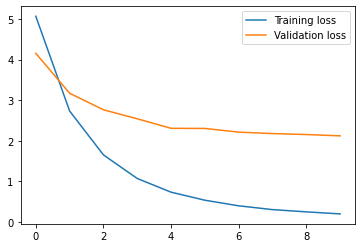

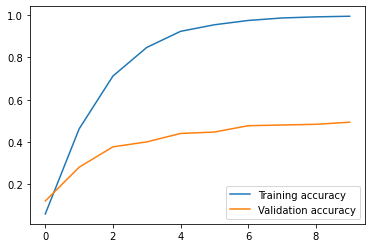

Test loss: 2.3493900299072266
Test accuracy: 0.4305967688560486


In [ ]:

#Entrenamiento y resultados
base_hist = base_model.fit(features_train,y_train,
                           batch_size=BATCH_SIZE,
                           epochs=10,
                           verbose=1,
                           validation_split=0.1)
mostrarEvolucion(base_hist)
base_score = base_model.evaluate(features_test, y_test, verbose=0)
print('Test loss:', base_score[0])
print('Test accuracy:', base_score[1])


Entrenamos el modelo anterior utilizando como entrada las características extraídas por ResNet50. Vemos que con solamente 10 épocas ya se aprecia la potencia del modelo: a pesar de estar entrenado con una base de datos diferente (ImageNet), se ha logrado una precisión superior al $40\%$. Sin embargo, también se ve como el sobreajuste del modelo es enorme

## b) Eliminar las capas finales FC y la salida, substituirlas por nuevas FC y salida y reentrenarlas con Caltech-UCSD

In [ ]:
#Eliminamos recursos de Colab
keras.backend.clear_session()
gc.collect()

#DEFINICION DEL MODELO
FC_model =Sequential()
FC_model.add(Dense(1024,activation='relu',input_shape=(2048,)))
FC_model.add(Dropout(0.7))
FC_model.add(Dense(512,activation='relu'))
FC_model.add(Dense(200,activation='softmax'))

FC_model.summary()

#Compilacion
FC_weights = compilarModelo(FC_model)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 200)               102600    
                                                                 
Total params: 2,725,576
Trainable params: 2,725,576
Non-trainable params: 0
_________________________________________________________________


En este caso añadimos más capas lineales, no solo la del clasificador. Además, introducimos un dropout bastante agresivo (de 0.7) antes de la segunda capa lineal. Con este dropout se busca disminuir el sobreajuste que se daba en el modelo anterior.

Por tanto, el modelo queda definido así:

$$\begin{array}{ccccc}
\textbf{Layer No.} & \textbf{Layer Type} & \textbf{Kernel Size} & \textbf{Dimension} & \textbf{Channels} \\
1                  & Linear              & -                    & 2048 |1024         & -                 \\
2                  & ReLu                & -                    & 1024 | 1024        & -                 \\
3                  & Dropout             & -                    & 1024 | 1024        & -                 \\
4                  & Linear              & -                    & 1024|512           & -                 \\
5                  & ReLu                & -                    & 512|512            & -                 \\
6                  & Linear              & -                    & 512|200            & -                 \\
7                  & Softmax             & -                    & 200|200            & -                
\end{array}$$

A continuación se entrena el modelo, dejando la discusión de resultados para el subapartado C).

Epoch 1/50
22/22 [==============================] - 1s 17ms/step - loss: 5.5060 - accuracy: 0.0096 - val_loss: 5.1108 - val_accuracy: 0.0433
Epoch 2/50
22/22 [==============================] - 0s 9ms/step - loss: 4.9113 - accuracy: 0.0500 - val_loss: 4.6967 - val_accuracy: 0.0633
Epoch 3/50
22/22 [==============================] - 0s 10ms/step - loss: 4.3367 - accuracy: 0.1044 - val_loss: 4.0289 - val_accuracy: 0.1333
Epoch 4/50
22/22 [==============================] - 0s 9ms/step - loss: 3.7345 - accuracy: 0.1585 - val_loss: 3.4477 - val_accuracy: 0.2067
Epoch 5/50
22/22 [==============================] - 0s 10ms/step - loss: 3.2077 - accuracy: 0.2244 - val_loss: 3.0889 - val_accuracy: 0.2100
Epoch 6/50
22/22 [==============================] - 0s 10ms/step - loss: 2.9056 - accuracy: 0.2711 - val_loss: 2.8289 - val_accuracy: 0.2967
Epoch 7/50
22/22 [==============================] - 0s 10ms/step - loss: 2.5703 - accuracy: 0.3333 - val_loss: 2.6867 - val_accuracy: 0.3167
Epoch 8/50
22/2

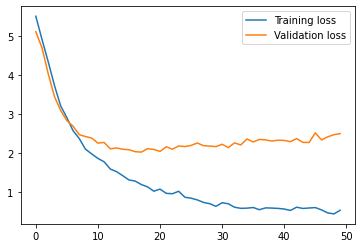

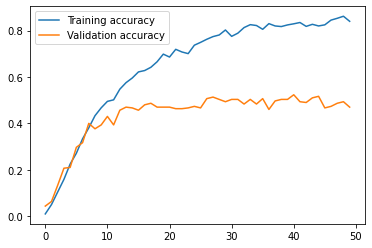

Test loss: 2.6868104934692383
Test accuracy: 0.4210352897644043


In [ ]:
#Entrenamiento y resultados
FC_hist = FC_model.fit(features_train,y_train,
                           batch_size=BATCH_SIZE,
                           epochs=50,
                           verbose=1,
                           validation_split=0.1)
mostrarEvolucion(FC_hist)
FC_score = FC_model.evaluate(features_test, y_test, verbose=0)
print('Test loss:', FC_score[0])
print('Test accuracy:', FC_score[1])

## c) Comparar resultados con el modelo anterior en el que unicamente se cambia y reentrena la capa de salida

En este caso podemos ver como la accuracy del modelo es similar, pero el sobreajuste, si bien sigue existiedto, es considerablemente menor. Además, se aprecian más picos en las gráficas, consecuencia de la capa de Dropout.

En caso de tener que elegir uno de los modelos, elegiría este último, pues si bien debe entrenarse un número de épocas mayor (50 vs 10 de la versión original) y la precisión es similar, el sobreajuste menor nos indica una precisión mayor en otros posibles casos de prueba.

## B.- Eliminar las capas de salida, FC y AveragePooling. En este momento tendrá un extractor de características. Añada nuevas capas que mezclen dichas características y den una clasificación. Entrene la red resultante y compare sus resultados con los resultados del punto.A

In [ ]:
# Obtenemos una nueva instancia de ResNet50 pero sin la capa de Pooling ni las FC
resnet = ResNet50(include_top=False,
                 weights="imagenet",
                 input_shape = INPUT_SHAPE,
                 pooling=False)

# Extraer las características de las imágenes con el modelo anterior.
features_train = resnet.predict(datagen_train.flow(x_train,batch_size = 1, shuffle = False),
                                           verbose=1)
features_test = resnet.predict(datagen_train.flow(x_test, batch_size = 1, shuffle = False),
                                           verbose=1)

3033/3033 [==============================] - 61s 20ms/step


En este caso, además de eliminar la última capa (clasificador), eliminamos también la capa de pooling anterior, lo cual provoca que la red devuelva las características en formas de tensores $(7,7,2048)$, sobre los cuales podemos aplicar convoluciones.

Mencionar sobreescriben las variables resnet y features (train y test) para ahorrar recursos en Colab e intentar evitar las grandes limitaciones que tiene la plataforma al trabajar con modelos tan grandes.

In [ ]:
#Eliminamos recursos innecesarios
keras.backend.clear_session()
gc.collect()

mix_model = Sequential()
mix_model.add(Conv2D(64, kernel_size=(3, 3),
                 input_shape=(7,7,2048),
                 use_bias=False))
mix_model.add(BatchNormalization())
mix_model.add(Activation('relu'))
mix_model.add(Flatten())
mix_model.add(Dropout(0.7))
mix_model.add(Dense(512,activation='relu'))
mix_model.add(Dense(200,activation='softmax'))

mix_model.summary()

#Compilacion e inicializacion de pesos (para esta parte del modelo)
mix_weights = compilarModelo(mix_model)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 5, 5, 64)          1179648   
                                                                 
 batch_normalization (BatchN  (None, 5, 5, 64)         256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 5, 5, 64)          0         
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dropout (Dropout)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 512)               819712    
                                                        

Tras realizar diversas pruebas, decidí añadir una capa convolucional $3\times3$ de 64 canales, lo suficientemente ancha como para aprovechar al máximo las características facilitadas por ResNet. Tras ella, se añade una capa de Batch Normalization, al estilo de lo realizado en el ejercicio 2 de la práctica. Probé a realizar otra convolución más manteniendo el padding en la primera (porque si no, tras la segunda convolución, tendríamos un tensor de dimensión (3,3,64) con muy poca dimensión espacial), imitando los bloques convolucionales utilizados en el ejercicio 2, pero las pruebas mostraban resultados peores, así que descarté la idea. También probé utilizando convoluciones más grandes ($5\times5$), pero al igual que con 2 convoluciones, el tamaño del tensor se reducía demasiado y empeoraba el desempeño de la red.

Además, eliminé una de las capas densas introducidas en el apartado anterior. Si se mantenía esa capa, la precisión disminuía enormemente. Intuyo que puede deberse a que, en este caso, la capa Flatten genera un tensor de dimensión 1600 (como se puede ver en la tabla inferior) frente a los 2048 que tenía en el apartado anterior. De esta manera , en el apartado anterior la primera capa densa lo convertía en uno de 1024 (mitad de tamaño), mientras que en este caso la reducción de tamaño era mucho menor (de 1600 a 1024), en lo cual parece estar el problema.

Tras estos cambios, el modero quedaría así:

$$\begin{array}{ccccc}
\textbf{Layer No.} & \textbf{Layer Type} & \textbf{Kernel Size} & \textbf{Dimension} & \textbf{Channels} \\
1                  & Conv2D              & 3                    & 7 | 5              & 64                \\
2                  & BatchNormalization  & -                    & 5|5                & -                 \\
3                  & ReLu                & -                    & 5|5                & -                 \\
4                  & Flatten             & -                    & 5|1600             & -                 \\
5                  & Dropout             & -                    & 1600|1600          & -                 \\
6                  & Linear              & -                    & 1600|512           & -                 \\
7                  & ReLu                & -                    & 512|512            & -                 \\
8                  & Linear              & -                    & 512|200            & -                 \\
9                  & Softmax             & -                    & 200|200            & -                
\end{array}$$

Epoch 1/25
22/22 [==============================] - 3s 63ms/step - loss: 5.5550 - accuracy: 0.0096 - val_loss: 5.1466 - val_accuracy: 0.0167
Epoch 2/25
22/22 [==============================] - 1s 39ms/step - loss: 4.8275 - accuracy: 0.0463 - val_loss: 4.4916 - val_accuracy: 0.0400
Epoch 3/25
22/22 [==============================] - 1s 41ms/step - loss: 3.9374 - accuracy: 0.1344 - val_loss: 3.6535 - val_accuracy: 0.1333
Epoch 4/25
22/22 [==============================] - 1s 40ms/step - loss: 2.9926 - accuracy: 0.2844 - val_loss: 3.3528 - val_accuracy: 0.2033
Epoch 5/25
22/22 [==============================] - 1s 42ms/step - loss: 2.3178 - accuracy: 0.4163 - val_loss: 2.9431 - val_accuracy: 0.2533
Epoch 6/25
22/22 [==============================] - 1s 41ms/step - loss: 1.7104 - accuracy: 0.5426 - val_loss: 2.7357 - val_accuracy: 0.3400
Epoch 7/25
22/22 [==============================] - 1s 40ms/step - loss: 1.3631 - accuracy: 0.6289 - val_loss: 2.7968 - val_accuracy: 0.3300
Epoch 8/25
22

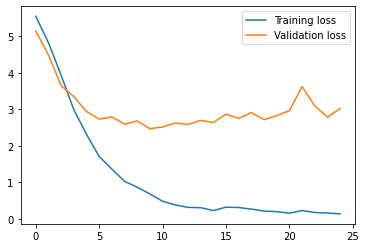

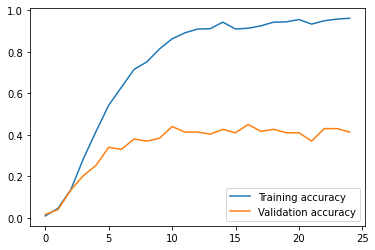

Test loss: 3.282001256942749
Test accuracy: 0.3709198832511902


In [ ]:

#Entrenamiento y resultados
mix_hist = mix_model.fit(features_train,y_train,
                           batch_size=BATCH_SIZE,
                           epochs=25,
                           verbose=1,
                           validation_split=0.1)
mostrarEvolucion(mix_hist)
mix_score = mix_model.evaluate(features_test, y_test, verbose=0)
print('Test loss:', mix_score[0])
print('Test accuracy:', mix_score[1])

Al ejecutar el modelo, se puede ver como el rendimiento es considerablemente peor que en los modelos anteriores, tanto en el original como el que aumenta las capas densas.

Por otro lado, se produce sobreajuste, no tanto como en el primer caso pero su mayor que en el segundo. Además, el tiempo de entrenamiento es mayor que en los casos anteriores, lo que descarta totalmente el uso de este modelo en un futuro.

#2.- Realizar un ajuste fino de toda la red ResNet50, al conjunto de datos. Caltech-UCSD.

Observación: Debido a la profundidad de ResNet50 y las limitaciones de RAM de Colab, el modelo tarda unos 10 minutos en ejecutarse (aproximadamente 1 minuto por época). Se añaden los registros de la última ejecución por si se prefieren consultar en lugar de ejecutarlo.

Epoch 1/10
85/85 [==============================] - 68s 723ms/step - loss: 4.4962 - accuracy: 0.1063 - val_loss: 4.5060 - val_accuracy: 0.0833
Epoch 2/10
85/85 [==============================] - 61s 715ms/step - loss: 2.0880 - accuracy: 0.4774 - val_loss: 3.5274 - val_accuracy: 0.2767
Epoch 3/10
85/85 [==============================] - 61s 714ms/step - loss: 0.8402 - accuracy: 0.7744 - val_loss: 3.1644 - val_accuracy: 0.2900
Epoch 4/10
85/85 [==============================] - 61s 715ms/step - loss: 0.3440 - accuracy: 0.9144 - val_loss: 2.9454 - val_accuracy: 0.3533
Epoch 5/10
85/85 [==============================] - 61s 714ms/step - loss: 0.1374 - accuracy: 0.9704 - val_loss: 3.2180 - val_accuracy: 0.3567
Epoch 6/10
85/85 [==============================] - 61s 714ms/step - loss: 0.0535 - accuracy: 0.9893 - val_loss: 2.3250 - val_accuracy: 0.4700
Epoch 7/10
85/85 [==============================] - 61s 713ms/step - loss: 0.0226 - accuracy: 0.9963 - val_loss: 2.0571 - val_accuracy: 0.5033

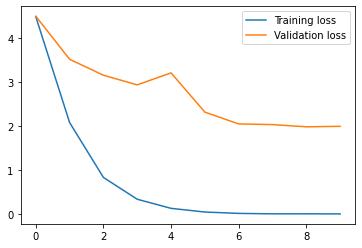

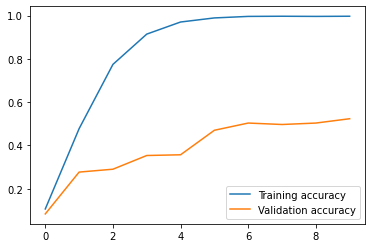

Test loss: 2.531304359436035
Test accuracy: 0.4362017810344696


In [ ]:
#Limpiamos recursos de Colab
gc.collect()
keras.backend.clear_session()

# Definir el modelo ResNet50 
resnet = ResNet50(include_top=False,
                 weights='imagenet',
                 pooling='avg',
                 input_shape = INPUT_SHAPE)

#DEFINICION DEL MODELO
x = resnet.output
x = Dense(1024, activation='relu')(x)
last = Dense(200, activation='softmax')(x)
FT_model = Model(inputs=resnet.input,outputs = last)

#Compilación
opt = SGD(learning_rate=0.01, momentum = 0.9, decay=1e-6, nesterov=True )
FT_model.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])

#Entrenamiento
FT_hist = FT_model.fit( datagen_train.flow(x_train,y_train, batch_size = 32, subset='training'),
                           validation_data = datagen_train.flow(x_train,y_train, batch_size = 32,subset = 'validation'),           
                           epochs=10,
                           verbose=1
                           )

#Resultados
mostrarEvolucion(FT_hist)
FT_score = FT_model.evaluate(datagen_test.flow(x_test, y_test,batch_size = 1,shuffle = False),verbose = 0)
print('Test loss:', FT_score[0])
print('Test accuracy:', FT_score[1])


En este apartado debemos realizar un ajuste fino sobre la red añadiéndole unas pocas capas finales. Esto es, vamos a reentrenar la red entera (incluyendo la parte de ResNet50) con el conjunto de Caltech, pero muy pocas épocas (unas 10). De esta manera, aprovechamos los pesos que nos proporciona ResNet (los cuales son muy buenos ya que está entrenada con ImageNet, un dataset de grandes dimensiones) pero los ajustamos ligeramente para que se adecúen mejor a nuestro problema particular.

En primer lugar, instanciamos el modelo ResNet, al cual eliminamos la última capa pero mantenemos la capa de *GlobalAveragePooling*, para que su salida sea un vector de 2048 características, que será la entrada de la siguiente capa del modelo.

En cuanto las capas añadidas, solo son 2 capas densas al final de ResNet, teniendo nuestro modelo final la siguiente estructura:

$$\begin{array}{ccccc}
\textbf{Layer No.} & \textbf{Layer Type} & \textbf{Kernel Size} & \textbf{Dimension} & \textbf{Channels} \\
1-50               & ResNet50              & -                    & 224 |2048          & -                 \\
51                 & Linear              & -                    & 2048 | 1024        & -                 \\
52                 & ReLu                & -                    & 1024 | 1024        & -                 \\
53                 & Linear              & -                    & 1024|200           & -                 \\
54                 & Softmax             & -                    & 200|200            & -                
\end{array}$$

En cuanto al proceso de compilación, en este caso no se utiliza la función de compilación del resto de ejercicios, ya que se cambia el método de optimización de Adam por SGD:


```
opt = SGD(learning_rate=0.01, momentum = 0.9, decay=1e-6, nesterov=True )
```
Esto es debido a que existe una gran diferencia de tamaño entre el número de imágenes con el que se entrenó ResNet y con el que intentamos reentrenarlo. Para que sea efectivo, se debe fijar un learning_rate bajo (para que los pesos se vean modificados). Tras realizar diversas pruebas con Adam, no se logró que la red aprendiera, y tras buscar en la documentación de Keras, se encontró que utilizar SGD con los parámetros anteriores hacía que la red se entrenase correctamente.

Finalmente, realizamos el entrenamiento y obtenemos los resultados.

La precisión alcanzada es similar a los modelos anteriores que solo añadían capas FC, y al igual que en ellos, existe bastante sobreentranamiento. Sin embargo, teniendo en cuenta que solo se entrenó durante 10 épocas, el resultado es satisfactorio.

Sin embargo, debido a las limitaciones hardware, en este caso el ajuste fino es inferior a la extracción de características, ya que el desempeño del primer modelo (extracción de características + clasificador) es similar, tardando unos 15 segundos frente a los más de 10 minutos de este. Ahora bien, en otra situación podría darse que el extractor no fuese tan eficiente y el ajuste fino fuese la única opción viable para aprovechar toda la potencia de un red preentrenada.



